In [180]:
import praw
import pandas as pd
import re
import string
import nltk
from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot
%matplotlib inline

In [181]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [184]:
def get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd):
    '''
    returns subreddit object with top 1000 subreddit posts
    
    '''

    with open(oa_script) as f:
    
        script = f.read().strip()

    with open(oa_secret) as f:
    
        secret = f.read().strip()

    with open(pwd) as f:
    
        pw = f.read().strip()
    
# get reddit object
    
    reddit = praw.Reddit(client_id=script,
                        client_secret=secret,
                        user_agent=app_name,
                        username='neurodivergent_ai',
                        password=pw)

    # get subreddit

    subreddit = reddit.subreddit(subreddit_name)

    # get top posts

    top = subreddit.top(limit=1000)

    for post in subreddit.top(limit=5):
    
        print(post.title, '\n')
        
    return top


In [185]:
#get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd):


donald_subreddit = get_subreddit('The_Donald', 'get_corpora', 
                                     'reddit_oa_script.txt', 'reddit_oa_secret.txt',
                                    'reddit_id.txt')

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



In [175]:
# iterate through reddit object, build dictionary, return dataframes
# return titles&posts df, plus whole df

def make_subreddit_df(subreddit_object):
    '''
    takes subreddit api object,
    returns as dataframe:
    
    * entire subreddit, all columns
    
    '''
    
    columns_dict = {'title': [],
                   'url': [],
                   'date': [],
                   'score': [],
                   'n_comments': [],
                   'body': []}
    
    # build dictionary
    
    for post in subreddit_object:
        
        columns_dict['title'].append(post.title)
        
        columns_dict['url'].append(post.url)
        
        columns_dict['date'].append(post.created)
        
        columns_dict['score'].append(post.score)
        
        columns_dict['n_comments'].append(post.num_comments)
        
        columns_dict['body'].append(post.selftext)
    
    # convert to dataframe
    
    subreddit_df = pd.DataFrame(columns_dict)
    
    return subreddit_df
        

In [186]:
donald_subreddit_df = make_subreddit_df(donald_subreddit)

In [187]:
donald_subreddit_df.head()

,title,url,date,score,n_comments,body
0,DONALD J. TRUMP DECLARED THE WINNER!,https://www.reddit.com/r/The_Donald/comments/5...,1.478706e+09,66710,12087,#Meme Magic is REAL.\n\n#Donald J. Trump is th...
1,I’m Donald J. Trump and I'm Your Next Presiden...,https://www.reddit.com/r/The_Donald/comments/4...,1.469687e+09,42126,20790,Hello The_Donald readers and the entire Reddit...
2,The New Algorithm Was Designed To Keep Preside...,https://i.sli.mg/gu0oHA.png,1.481092e+09,40978,832,
3,CNN will soon be #1...when searching for the t...,https://i.redd.it/7jeyhzgku65y.png,1.482472e+09,37279,724,
4,ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....,https://www.reddit.com/r/The_Donald/comments/5...,1.478702e+09,36614,1685,Now that we have proven our commitment to the ...


In [300]:
# text cleaning: 2 different versions
# light clean for model training, heavy clean for vocab work

def light_clean(doc):
    '''
    lightly cleans input doc for
    word embedding training:
    
    * tokenizes
    * lowercase
    * removes punctuation & non-alpha characters
    
    returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # punctuation list
    
    punctuation = string.punctuation
    
    # set up regex filter
    
    rgx_punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # apply filter
    
    no_punct_tokens = [rgx_punct_filter.sub('', char) for char in split_tokens]
    
    # alpha tokens only
    
    alpha_tokens = [t for t in no_punct_tokens if t.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    return lower_tokens

def super_clean(doc):
    '''
    cleans a single input document.
    preps for vocabulary analysis.
    applies more processing than
    light_clean():
    
    * tokenizes
    * lowercase
    * removes punctuation & numbers
    * removes stopwords
    
    returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # grab punctuation list
    
    punctuation = string.punctuation
    
    # setup re filter
    
    rgx_punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # apply filter
    
    no_punct_tokens = [rgx_punct_filter.sub('', char) for char in split_tokens]
    
    # take out numbers & any other non-alpha characters
    
    alpha_tokens = [i for i in no_punct_tokens if i.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    # get stop words
    
    stop_words = set(stopwords.words('english'))
    
    # filter out stopwords
    
    go_tokens = [t for t in lower_tokens if not t in stop_words]
    
    # remove very short tokens
    
    clean_tokens = [word for word in go_tokens if len(word) > 1]
    
    return clean_tokens

In [299]:
def clean_all_docs(docs):
    
    clean_docs = []
    
    for doc in docs:
        
        doc = super_clean(doc)
        
        if doc:
            
            clean_docs.append(doc)
    
    return clean_docs


In [236]:
titles_df = donald_subreddit_df['title']

posts_df = donald_subreddit_df['body']

donald_clean_titles = clean_all_docs(titles_df)

donald_clean_posts = clean_all_docs(posts_df)


In [203]:
print(donald_clean_titles[4])
print(donald_clean_posts[2])

['celebrities', 'vowed', 'leave', 'usa', 'trump', 'wins', 'demand', 'follow']
['proven', 'commitment', 'cause', 'voiced', 'acted', 'patriotism', 'odds', 'constant', 'criticism', 'world', 'us', 'call', 'elitist', 'hollywood', 'celebrities', 'vowed', 'betray', 'country', 'leave', 'abandon', 'shun', 'spent', 'careers', 'milking', 'posh', 'lifestyles', 'ask', 'nay', 'demand', 'follow', 'claims', 'leave', 'country', 'americans', 'spoken', 'brushed', 'us', 'movement', 'somehow', 'us', 'forgetting', 'us', 'made', 'fuck', 'think', 'good', 'us', 'well', 'good', 'follow', 'vapid', 'empty', 'threat', 'mistakenly', 'pridefully', 'consider', 'get', 'fuck', 'fame', 'celebrity', 'status', 'despicable', 'shall', 'say', 'deplorable', 'better', 'us', 'important', 'us', 'would', 'nothing', 'without', 'us', 'dare', 'pretend', 'us', 'list', 'demand', 'leave', 'asap', 'amy', 'unfunny', 'schumer', 'lena', 'dunham', 'barbra', 'streisand', 'bryan', 'cranston', 'miley', 'cyrus', 'amy', 'schumer', 'jon', 'stewar

In [207]:
donald_clean_corpus = donald_clean_titles + donald_clean_posts

In [208]:
def train_w2v_model(docs):
    '''
    trains word2vec model on input set of docs.
    fits PCA projection to 2d space.
    prints 2d visualization of words in vector space.
    returns trained model.
    
    '''
    
    # train w2v model 
    
    w2v_model = Word2Vec(docs, min_count=1)
    
    # get vocab
    
    vector_vocab = w2v_model[w2v_model.wv.vocab]
    
    # fit PCA model / 2d projection
    
    pca_model = PCA(n_components=2)
    
    pca_projection = pca_model.fit_transform(vector_vocab)
    
    # plot
    
    pyplot.scatter(pca_projection[:, 0], pca_projection[:, 1])
    
    # plot with words
    
    vocab_list = list(w2v_model.wv.vocab)
    
    for i, word in enumerate(vocab_list):
        
        pyplot.annotate(word, xy=(pca_projection[i, 0], pca_projection[i, 1]))  
    
    return w2v_model
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


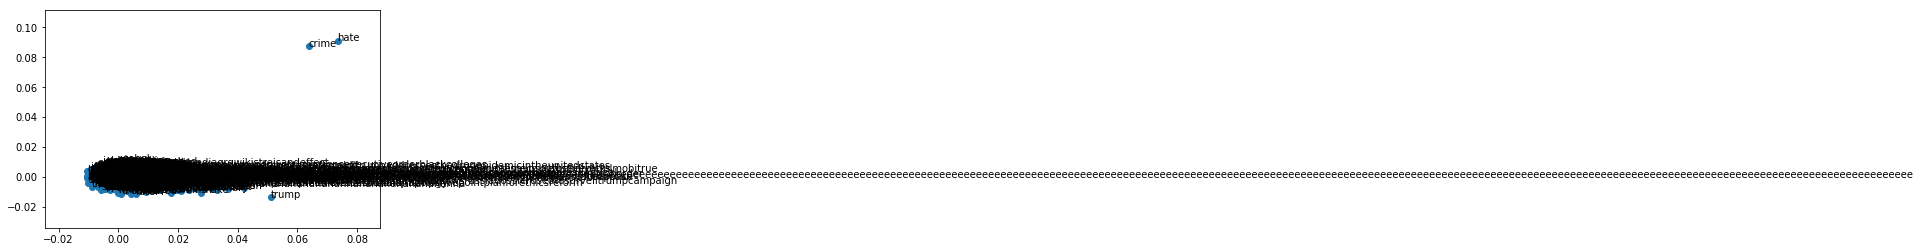

In [209]:
donald_model = train_w2v_model(donald_clean_corpus)

In [212]:
def get_cos_sim(model, word_1, word_2):
    
    return model.wv.similarity(word_1, word_2)


def compare_cos_sim(model, word_list, comp_word):
    
    cos_sim_list = []
    
    for word in word_list:
        
        cos_sim = get_cos_sim(model, word, comp_word)
        
        in_list = []
        
        in_list.append(comp_word)
        
        in_list.append(word)
        
        in_list.append(cos_sim)
        
        cos_sim_list.append(in_list)
    
    return cos_sim_list    
            

In [223]:
# make contrived list

list_A = ['president', 'qualified', 'people', 'email', 'prison', 'crooked']

word_1 = 'trump'

word_2 = 'clinton'


In [224]:
# compare_cos_sim(model, word_list, comp_word)

cos_sims_list_1 = compare_cos_sim(donald_model, list_A, word_1)

cos_sims_list_2 = compare_cos_sim(donald_model, list_A, word_2)

In [225]:
print(cos_sims_list_1, '\n')
print(cos_sims_list_2)

[['trump', 'president', 0.6437116323233487], ['trump', 'qualified', 0.016517045750558453], ['trump', 'people', 0.6575355789812684], ['trump', 'email', 0.5199953341420535], ['trump', 'prison', 0.08070563753409733], ['trump', 'crooked', 0.15875857307517885]] 

[['clinton', 'president', 0.5937849527280563], ['clinton', 'qualified', -0.031306804942539644], ['clinton', 'people', 0.6359931049952696], ['clinton', 'email', 0.543810485270158], ['clinton', 'prison', 0.1451578162503217], ['clinton', 'crooked', 0.06423235526010126]]


In [226]:
def comp_cos_sim_lists(model, list_1, list_2):
    
    cos_sim_list = []
    
    for word in list_1:
        
        if word not in list_2:
            
            sim_line = compare_cos_sim(model, list_2, word)
            
            cos_sim_list.append(sim_line)
    
    return cos_sim_list
            

In [321]:
list_B = ['donald', 'trump', 'hillary', 'clinton']

cos_sim_lists = comp_cos_sim_lists(donald_model, list_A, list_B)

# test

cs_list_df = pd.DataFrame(cos_sim_lists)

print(cos_sim_lists)

[[['president', 'donald', 0.4253502350796358], ['president', 'trump', 0.6437116323233487], ['president', 'hillary', 0.504059205062843], ['president', 'clinton', 0.5937849527280563]], [['qualified', 'donald', 0.005270225743883399], ['qualified', 'trump', 0.016517045750558453], ['qualified', 'hillary', 0.14810712360137543], ['qualified', 'clinton', -0.031306804942539644]], [['people', 'donald', 0.5852895787194283], ['people', 'trump', 0.6575355789812684], ['people', 'hillary', 0.6112779011272428], ['people', 'clinton', 0.6359931049952696]], [['email', 'donald', 0.2881382393257101], ['email', 'trump', 0.5199953341420535], ['email', 'hillary', 0.4054012103563048], ['email', 'clinton', 0.543810485270158]], [['prison', 'donald', 0.16316250574594812], ['prison', 'trump', 0.08070563753409733], ['prison', 'hillary', 0.12900912858620756], ['prison', 'clinton', 0.1451578162503217]], [['crooked', 'donald', 0.1519629446522846], ['crooked', 'trump', 0.15875857307517885], ['crooked', 'hillary', 0.073

In [322]:
cs_list_df

,0,1,2,3
0,"[president, donald, 0.4253502350796358]","[president, trump, 0.6437116323233487]","[president, hillary, 0.504059205062843]","[president, clinton, 0.5937849527280563]"
1,"[qualified, donald, 0.005270225743883399]","[qualified, trump, 0.016517045750558453]","[qualified, hillary, 0.14810712360137543]","[qualified, clinton, -0.031306804942539644]"
2,"[people, donald, 0.5852895787194283]","[people, trump, 0.6575355789812684]","[people, hillary, 0.6112779011272428]","[people, clinton, 0.6359931049952696]"
3,"[email, donald, 0.2881382393257101]","[email, trump, 0.5199953341420535]","[email, hillary, 0.4054012103563048]","[email, clinton, 0.543810485270158]"
4,"[prison, donald, 0.16316250574594812]","[prison, trump, 0.08070563753409733]","[prison, hillary, 0.12900912858620756]","[prison, clinton, 0.1451578162503217]"
5,"[crooked, donald, 0.1519629446522846]","[crooked, trump, 0.15875857307517885]","[crooked, hillary, 0.07375405836368132]","[crooked, clinton, 0.06423235526010126]"


In [241]:
def join_corpus(df):
    
    corpus = list(df['title']) + list(df['body'])
    
    return corpus

In [242]:
donald_corpus = join_corpus(donald_subreddit_df)

print(len(donald_corpus))

1996


In [243]:
donald_clean_corpus_test = clean_all_docs(donald_corpus)

print(donald_clean_corpus_test[6])

['hey', 'admins', 'found', 'picture', 'wifes', 'boyfriends', 'president']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


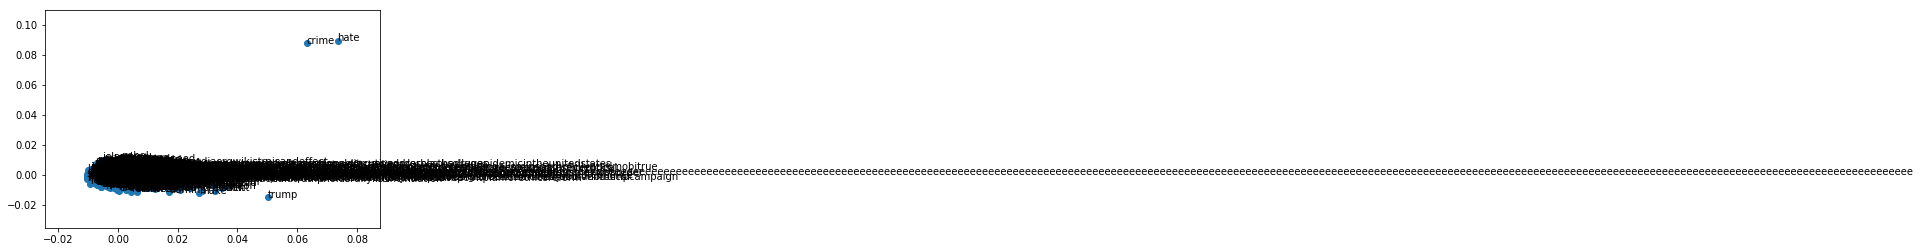

In [244]:
donald_model_test = train_w2v_model(donald_clean_corpus_test)

In [245]:
cos_sim_lists_test = comp_cos_sim_lists(donald_model_test, list_A, list_B)

print(cos_sim_lists_test)

[[['president', 'donald', 0.41455337118201996], ['president', 'trump', 0.6355606990334444], ['president', 'hillary', 0.4914439467343301], ['president', 'clinton', 0.5666152362185881]], [['qualified', 'donald', -0.0008163028051628995], ['qualified', 'trump', 0.019144379178387953], ['qualified', 'hillary', 0.1495474711068858], ['qualified', 'clinton', -0.04061095000207812]], [['people', 'donald', 0.5621708519888343], ['people', 'trump', 0.656525562012981], ['people', 'hillary', 0.6015504624283076], ['people', 'clinton', 0.6174236217207607]], [['email', 'donald', 0.24544201743430474], ['email', 'trump', 0.4826150336957016], ['email', 'hillary', 0.3718579122250961], ['email', 'clinton', 0.5145453198599479]], [['prison', 'donald', 0.15686588488233605], ['prison', 'trump', 0.08462507127824795], ['prison', 'hillary', 0.1314446111931134], ['prison', 'clinton', 0.1519961556050803]], [['crooked', 'donald', 0.14722588163090009], ['crooked', 'trump', 0.15105087253448274], ['crooked', 'hillary', 0.

In [263]:
def get_vocab(docs):
    
    words = []
    
    for doc in docs:
        
        # super_clean() removes stopwords
        # returns a more useful vocabulary for analysis
        
        doc = super_clean(doc)
        
        for word in doc:
            
            words.append(word)
    
    word_counts = Counter(words)
    
    word_counts = pd.DataFrame.from_dict(word_counts, orient='index')
    
    # return df sorted by word frequency
    
    return word_counts.sort_values(by=[0], ascending=False)

In [265]:
donald_vocab = get_vocab(donald_corpus)

print(donald_vocab)

                      0
trump               342
us                  154
president           123
clinton             121
people              118
reddit              114
like                102
would                95
hillary              90
one                  80
donald               78
get                  77
media                66
post                 66
make                 66
campaign             65
going                61
even                 61
new                  59
time                 59
foundation           58
news                 57
dont                 57
email                57
hate                 56
first                56
rall                 54
see                  54
know                 52
support              50
...                 ...
forgetting            1
videos                1
toledo                1
kavabrah              1
rude                  1
elevator              1
screamers             1
professionals         1
professionally        1
identical       

In [304]:
# just for fun

trump_elitist = get_cos_sim(donald_model_test, 'trump', 'elitist')

clinton_elitist = get_cos_sim(donald_model_test, 'clinton', 'elitist')

print(trump_elitist, clinton_elitist)

0.03583062034053362 0.14346369689362046


In [297]:
def get_top_and_bottom(df, number):
    
    top = df[:number][:]
    
    bottom = df[-number:][:]
    
    return top, bottom

In [298]:
top_25, bottom_25 = get_top_and_bottom(donald_vocab, 25)

print(top_25)
print(bottom_25)

              0
trump       342
us          154
president   123
clinton     121
people      118
reddit      114
like        102
would        95
hillary      90
one          80
donald       78
get          77
media        66
post         66
make         66
campaign     65
going        61
even         61
new          59
time         59
foundation   58
news         57
dont         57
email        57
hate         56
                    0
elevator            1
screamers           1
professionals       1
professionally      1
identical           1
basement            1
troublemakers       1
insurmountable      1
crush               1
machine             1
spotty              1
brushed             1
et                  1
constant            1
criticism           1
elitist             1
abandon             1
shun                1
prodoma             1
milking             1
posh                1
lifestyles          1
nay                 1
spoken              1
httpimgurcomayzkqt  1


## text prep pipeline

In [316]:
def text_prep_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number):
    
    # get_subreddit()
    #get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd)
    
    subreddit = get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd)
        
    # make_subreddit_df()
    #make_subreddit_df(subreddit_object)
    
    subreddit_df = make_subreddit_df(subreddit)
    
    # join_corpus()
    #join_corpus(df)
    
    raw_corpus = join_corpus(subreddit_df)
    
    # clean_all_docs()
    #clean_all_docs(docs)
    
    clean_corpus = clean_all_docs(raw_corpus)
    
    # get_vocab()
    #get_vocab(docs)
    
    # get vocab takes raw corpus, NOT clean
    vocab_df = get_vocab(raw_corpus)
    
    # get_top_and_bottom()
    #get_top_and_bottom(df, number)
    #return top, bottom
    
    top, bottom = get_top_and_bottom(vocab_df, vocab_number)
    
    return subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom

## test text_prep_pipeline

In [317]:
'''
donald_subreddit = get_subreddit('The_Donald', 'get_corpora', 
                                     'reddit_oa_script.txt', 'reddit_oa_secret.txt',
                                    'reddit_id.txt')
                                    '''
# text_prep_pipeline(subreddit_name, app_name, oa_script, pwd, vocab_number)
# return subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom

d_df_2, d_raw_corpus_2, d_clean_corpus_2, d_vocab_df_2, d_top_2, d_bottom_2 = text_prep_pipeline('The_Donald','get_corpora','reddit_oa_script.txt','reddit_oa_secret.txt','reddit_id.txt', 25)

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



In [318]:
print(d_df_2.head(), '\n')
print(d_raw_corpus_2[6], '\n')
print(d_clean_corpus_2[6], '\n')
print(d_vocab_df_2.head(), '\n')
print(d_top_2.head(), '\n')
print(d_bottom_2.head())

                                               title  \
0               DONALD J. TRUMP DECLARED THE WINNER!   
1  I’m Donald J. Trump and I'm Your Next Presiden...   
2  The New Algorithm Was Designed To Keep Preside...   
3  CNN will soon be #1...when searching for the t...   
4  ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....   

                                                 url          date  score  \
0  https://www.reddit.com/r/The_Donald/comments/5...  1.478706e+09  66718   
1  https://www.reddit.com/r/The_Donald/comments/4...  1.469687e+09  42117   
2                        https://i.sli.mg/gu0oHA.png  1.481092e+09  40978   
3                 https://i.redd.it/7jeyhzgku65y.png  1.482472e+09  37283   
4  https://www.reddit.com/r/The_Donald/comments/5...  1.478702e+09  36620   

   n_comments                                               body  
0       12086  #Meme Magic is REAL.\n\n#Donald J. Trump is th...  
1       20773  Hello The_Donald readers and the entire Reddit...  

## training pipeline

In [352]:
def train_pipeline(docs, term_list_A, term_list_B):
    
    # train model
    
    trained_w2v_model = train_w2v_model(docs)
    
    term_cos_sims = comp_cos_sim_lists(trained_w2v_model, term_list_A, term_list_B)
    
    return trained_w2v_model, term_cos_sims

## test train pipeline

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


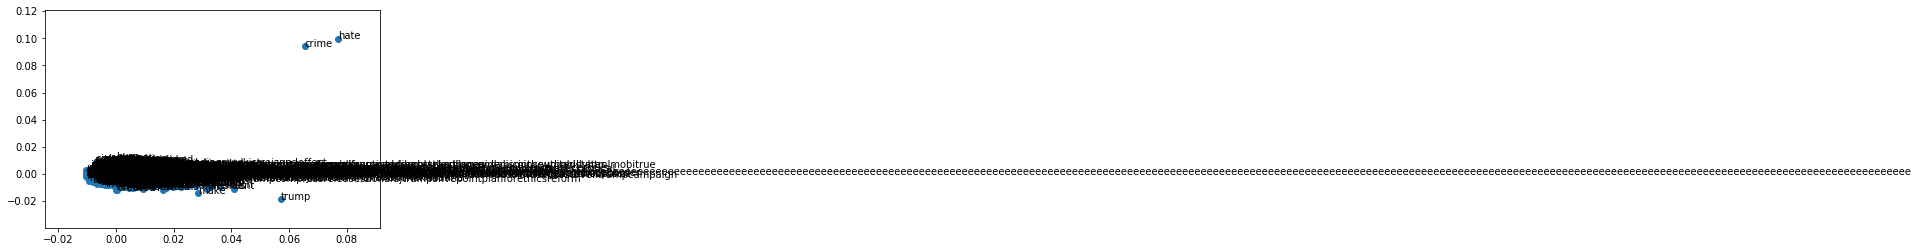

In [353]:
d_model_2, terms_list = train_pipeline(d_clean_corpus_2, list_A, list_B)

In [354]:
print(terms_list)

[[['president', 'donald', 0.45488072802100576], ['president', 'trump', 0.682874119603753], ['president', 'hillary', 0.5134383698977982], ['president', 'clinton', 0.6063551093197314]], [['qualified', 'donald', 0.018904459818019727], ['qualified', 'trump', 0.031560459613745206], ['qualified', 'hillary', 0.15278231570738632], ['qualified', 'clinton', -0.02559401746575786]], [['people', 'donald', 0.6011536382496974], ['people', 'trump', 0.6658296414862264], ['people', 'hillary', 0.5796963522776016], ['people', 'clinton', 0.6166025820180141]], [['email', 'donald', 0.29858542241525854], ['email', 'trump', 0.5371656319764926], ['email', 'hillary', 0.39888551718100373], ['email', 'clinton', 0.5523375330909384]], [['prison', 'donald', 0.16820644017846734], ['prison', 'trump', 0.09213555520184287], ['prison', 'hillary', 0.12588398282686752], ['prison', 'clinton', 0.13803410697609403]], [['crooked', 'donald', 0.14273233076628533], ['crooked', 'trump', 0.14831232315844087], ['crooked', 'hillary', 

## final pipeline

* run `text_prep_pipeline()` once per subreddit

* run `train_pipeline()` three times per subreddit

* return 3 models & 1 list of mean cos similarities


In [383]:
def list_sims_for_mean(sim_comp_list):
    
    sims_for_mean = []
    
    for sub_list in sim_comp_list:
        
        for i in sub_list:
            
            # grab 3rd item/cos sim
            
            sim = i[2]
        
            sims_for_mean.append(sim)
    
    return sims_for_mean


        
def get_sim_means(sims_for_mean_1, sims_for_mean_2, sims_for_mean_3):
    
    sim_means_list = []
    
    for i in range(len(sims_for_mean_1)):
        
        sim_mean = (sims_for_mean_1[i] + sims_for_mean_2[i] + sims_for_mean_3[i]) / 3
        
        sim_means_list.append(sim_mean)
    
    return sim_means_list
    


def get_mean_cos_sim(sim_list_1, sim_list_2, sim_list_3):
    
    sims_1 = list_sims_for_mean(sim_list_1)
    
    sims_2 = list_sims_for_mean(sim_list_2)
    
    sims_3 = list_sims_for_mean(sim_list_3)
    
    means_list = get_sim_means(sims_1, sims_2, sims_3)
    
    mean_cos_sims = []
    
    # make new list with comparison terms
    
    for sub_lists in sim_list_1:
        
        for i in sub_lists:
            
            local_sim_list = []
            
            local_sim_list.append(i[0])
            
            local_sim_list.append(i[1])
            
            mean_cos_sims.append(local_sim_list)
            
    # append mean cos sim values
        
    for i in range(len(mean_cos_sims)):
        
        mean_cos_sims[i].append(means_list[i])
    
    return mean_cos_sims
                


## test mean cos sims

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


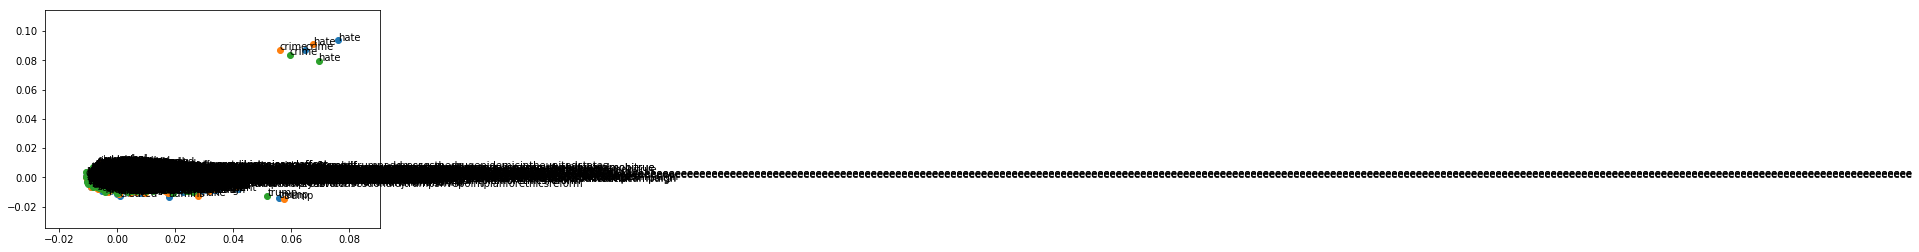

In [356]:
#train_pipeline(docs, term_list_A, term_list_B)
#d_df_2, d_raw_corpus_2, d_clean_corpus_2, d_vocab_df_2, d_top_2, d_bottom_2
#return trained_w2v_model, term_cos_sims

d_test_model_A, sims_A = train_pipeline(d_clean_corpus_2, list_A, list_B)
d_test_model_B, sims_B = train_pipeline(d_clean_corpus_2, list_A, list_B)
d_test_model_C, sims_C = train_pipeline(d_clean_corpus_2, list_A, list_B)


In [385]:
#get_mean_cos_sim(sim_list_1, sim_list_2, sim_list_3)

sims_test = get_mean_cos_sim(sims_A, sims_B, sims_C)

sims_test_df = pd.DataFrame(sims_test)

print(sims_A, '\n')
print(sims_B, '\n')
print(sims_C, '\n')
print(sims_test)

print(sims_test_df)

[[['president', 'donald', 0.40349877178627663], ['president', 'trump', 0.6481701610132141], ['president', 'hillary', 0.4612998274838706], ['president', 'clinton', 0.5620991143989674]], [['qualified', 'donald', -0.0020818439950853647], ['qualified', 'trump', 0.017293174993139072], ['qualified', 'hillary', 0.14260227857549024], ['qualified', 'clinton', -0.04599122260875025]], [['people', 'donald', 0.5910153494823733], ['people', 'trump', 0.6863760919177472], ['people', 'hillary', 0.60208476411483], ['people', 'clinton', 0.6307801129550942]], [['email', 'donald', 0.26861592233195625], ['email', 'trump', 0.5252510571152227], ['email', 'hillary', 0.3931452160357817], ['email', 'clinton', 0.5421025925377752]], [['prison', 'donald', 0.15105325563102048], ['prison', 'trump', 0.08719473993914037], ['prison', 'hillary', 0.12295136016708598], ['prison', 'clinton', 0.1335067752234638]], [['crooked', 'donald', 0.13572123886840984], ['crooked', 'trump', 0.1517201983256919], ['crooked', 'hillary', 0.

## final pipeline

In [391]:
def final_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number, term_list_A, term_list_B):
    
    #text_prep_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number)
    # return subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom
    
    subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom = text_prep_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number)
    
    # save data to file(s)
    
    # prepare to export as CSVs
    # first generate unique names
    # subreddit_df, raw_corpus, clean_corpus, vocab_df
    
    subreddit_df_filename = app_name + '_subreddit.csv'
    
    raw_corpus_filename = app_name + '_raw_corpus.csv'
    
    clean_corpus_filename = app_name + '_clean_corpus.csv'
    
    vocab_df_filename = app_name + '_vocab.csv'
    
    # next convert lists to DataFrames
    
    raw_corpus_df = pd.DataFrame(raw_corpus)
    
    clean_corpus_df = pd.DataFrame(clean_corpus)
    
    # export to CSVs using unique filenames
    
    subreddit_df.to_csv(subreddit_df_filename)
    
    raw_corpus_df.to_csv(raw_corpus_filename)
    
    clean_corpus_df.to_csv(clean_corpus_filename)
    
    vocab_df.to_csv(vocab_df_filename)
    
    
    #train_pipeline(docs, term_list_A, term_list_B)
    # return trained_w2v_model, term_cos_sims
    
    # train 3 models
    
    model_1, cos_sims_1 = train_pipeline(clean_corpus, term_list_A, term_list_B)
    
    model_2, cos_sims_2 = train_pipeline(clean_corpus, term_list_A, term_list_B)
    
    model_3, cos_sims_3 = train_pipeline(clean_corpus, term_list_A, term_list_B)
    
    final_sims_list = get_mean_cos_sim(cos_sims_1, cos_sims_2, cos_sims_3)
    
    final_sims_df = pd.DataFrame(final_sims_list)
    
    # display results
    
    print('top vocabulary: \n')
    
    print(top, '\n')
    
    print('bottom vocabulary: \n')
    
    print(bottom, '\n')
    
    print('mean cosine similarities: \n')
    
    print(final_sims_df)
    
    return model_1, model_2, model_3, final_sims_list, top, bottom
    

## testing final pipeline

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


top vocabulary: 

              0
trump       342
us          154
president   123
clinton     121
people      118
reddit      114
like        102
would        95
hillary      90
one          80
donald       78
get          77
post         66
make         66
media        66
campaign     65
going        61
even         61
new          59
time         59
foundation   58
email        57
dont         57
news         57
first        56 

bottom vocabulary: 

                    0
prosecutors         1
cleans              1
fears               1
familiar            1
occurrence          1
taibbi              1
rolling             1
merely              1
arm                 1
nfl                 1
yates               1
comply              1
refusal             1
maxine              1
waters              1
posing              1
ukraine             1
placements          1
flynn               1
investigated        1
kayne               1
smeared             1
uncle               1
tom            

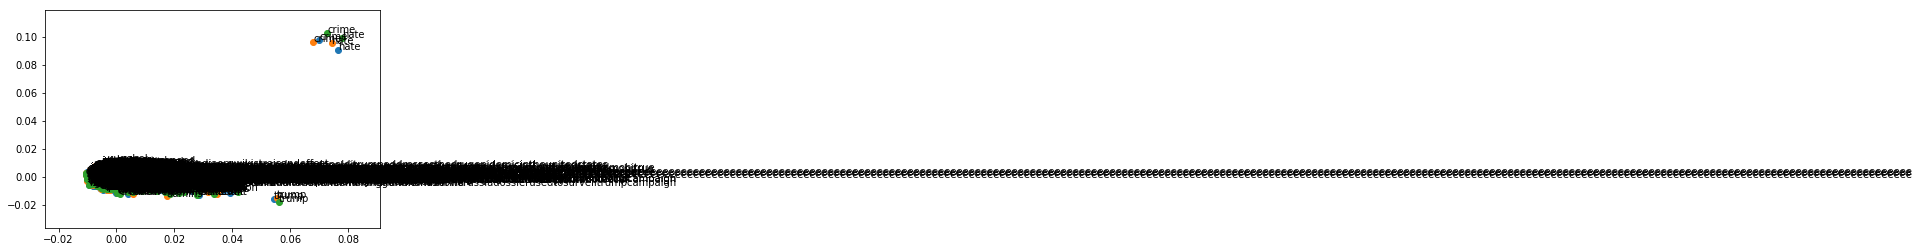

In [392]:
d_test_model_1, d_test_model_2, d_test_model_3, d_test_sims_list, d_test_top, d_test_bottom = final_pipeline('The_Donald', 'get_corpora', 'reddit_oa_script.txt', 'reddit_oa_secret.txt', 'reddit_id.txt', 25, list_A, list_B)


## testing word lists

1) possible alt-right terms

* ‘kek’, 'kekistan’, ‘normies’, ‘pepe’, ‘deus vult’, ‘tendies’, ‘god emperor trump’, ‘SJW’, ‘snowflake’, ‘pandering’, ‘tumblr’, ‘feminist’, ‘triggering’, ‘gamergate’, ‘virtue signalling’, ‘females’, ‘cuck’, ‘bitch’, ‘chad’, ‘alpha’, ‘beta’, ‘omega’, ‘globalist scum’, ‘establishment’, ‘puppets’, ‘elites’, ‘masters’, ‘george soros’, ‘cultural marxist’





In [461]:

# words that don't appear in The_Donald vocab:
#'kekistan'
#'normies'
#'deus'
#'vult'
#'SJW' -> 'sjw' (because of lowercase)
#'pandering'
#'tumblr'
#'gamergate'
#'signaling'
#'females' -> 'female'
#'chad'
#'beta'
#'omega'
#'puppets'
#'elites'
#'masters'
#'marxist'

# words i removed:
#'george soros' -> 'soros' (vocab is tokenized, 'george' is less useful)
#'cultural' ('marxism' did not exist in the vocabulary, making 'cultural' less useful)
#'scum' (wasn't particularly relevant)
#'kek' (relevance)
#'tendies' (didn't understand context)
#'sjw' (relevance)
#'snowflake' (relevance)
#'triggering' (relevance)
#'virtue' 'signalling' did not exist in vocab, making 'virtue' less useful
#'female'
#'feminist' (relevance)
#'globalist' (relevance)

# words i added:
#'prison'
#'email'
#'corrupt'


In [542]:
terms_list_A_test_1 = ['pepe', 'god', 'emperor', 'cuck', 'bitch', 
                       'alpha', 'establishment', 'soros', 'prison', 
                       'email', 'corrupt']

terms_list_B_test_1 = ['trump', 'clinton', 'sanders', 'liberal', 'conservative']


terms_test_1_result = comp_cos_sim_lists(d_test_model_1, terms_list_A_test_1, terms_list_B_test_1)

In [543]:

terms_test_1_result

[[['pepe', 'trump', 0.23439466251679417],
  ['pepe', 'clinton', 0.14553300334302668],
  ['pepe', 'sanders', 0.05182610904233882],
  ['pepe', 'liberal', -0.11625363742379752],
  ['pepe', 'conservative', 0.05119611022892136]],
 [['god', 'trump', 0.21578022512562972],
  ['god', 'clinton', 0.12407597769032738],
  ['god', 'sanders', 0.09398939088936471],
  ['god', 'liberal', -0.04319101903279807],
  ['god', 'conservative', 0.0003626665766693982]],
 [['emperor', 'trump', 0.31317195294480044],
  ['emperor', 'clinton', 0.1630202948224156],
  ['emperor', 'sanders', 0.18129643990693453],
  ['emperor', 'liberal', 0.049341773284569596],
  ['emperor', 'conservative', 0.1158404500741101]],
 [['cuck', 'trump', 0.23077357915551036],
  ['cuck', 'clinton', 0.1804662037128091],
  ['cuck', 'sanders', 0.2146649327736989],
  ['cuck', 'liberal', -0.1114710677358435],
  ['cuck', 'conservative', -0.03629408019621261]],
 [['bitch', 'trump', 0.028123457851630302],
  ['bitch', 'clinton', 0.16726709831362305],
  [

## testing pipeline + word list on new subreddit

### r/feminism subreddit

Some words from Maisie Williams 

This sadly happens all to often. 

This can never go away, this needs to continue to get posted over and over and over again. This should never be forgotten 

About abortion 

Got this on my feed today. 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


top vocabulary: 

            0
women     312
men       147
woman     120
rape       86
feminist   82
like       82
sexual     81
people     74
feminism   70
female     69
man        61
first      60
time       58
male       57
im         56
one        56
get        54
dont       51
sex        50
us         50
would      49
girls      45
know       45
never      45
even       45 

bottom vocabulary: 

              0
funds         1
gordonlevitt  1
autonomy      1
costars       1
swimsuit      1
portion       1
competition   1
outward       1
chairwoman    1
blocks        1
buried        1
joseph        1
hatespeech    1
slams         1
arrest        1
safer         1
heroeines     1
capes         1
glasses       1
suits         1
amounts       1
merry         1
holidays      1
sois          1
heartbroken   1 

mean cosine similarities: 

          0         1         2
0       god     trump  0.137764
1       god   clinton  0.002737
2       god   sanders  0.043587
3       god       men

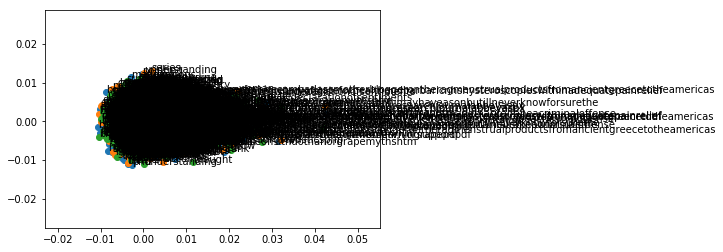

In [544]:
feminism_words_A = ['god', 'bitch', 
                        'prison', 
                       'good', 'evil', 'smart', 'assault', 'honest', 'brains']

feminism_words_B = ['trump', 'clinton', 'sanders', 'men', 'women', 'feminist']


feminism_model_1, feminism_model_2, feminism_model_3, feminism_cos_sims, feminism_top_vocab, feminism_bottom_vocab = final_pipeline('feminism', 'feminism', 'r_feminism_script.txt', 'r_feminism_secret.txt', 'reddit_id.txt', 25, feminism_words_A, feminism_words_B)

In [549]:
feminism_words_A_test = ['god', 'bitch', 
                        'prison', 
                       'good', 'evil', 'smart', 'assault', 'honest', 'brains', 'president', 'feminist']

feminism_words_B_test = ['trump', 'clinton', 'sanders', 'men', 'women', 'feminist']


fem_cos = comp_cos_sim_lists(feminism_model_1, feminism_words_A_test, feminism_words_B_test)

In [550]:
fem_cos

[[['god', 'trump', 0.13779304677659518],
  ['god', 'clinton', 0.002717417121301127],
  ['god', 'sanders', 0.043581579186423754],
  ['god', 'men', 0.2119683282584997],
  ['god', 'women', -0.06292638606480967],
  ['god', 'feminist', 0.06601769710017819]],
 [['bitch', 'trump', -0.06841432263990432],
  ['bitch', 'clinton', 0.15140923149860208],
  ['bitch', 'sanders', -0.07474065376014351],
  ['bitch', 'men', 0.03579185675409274],
  ['bitch', 'women', -0.059528879332452184],
  ['bitch', 'feminist', -0.02154257102692103]],
 [['prison', 'trump', -0.04732024050454451],
  ['prison', 'clinton', -0.041152893587981965],
  ['prison', 'sanders', 0.008242491430874889],
  ['prison', 'men', 0.28757566358948733],
  ['prison', 'women', 0.25739822824863434],
  ['prison', 'feminist', 0.32226977407872326]],
 [['good', 'trump', 0.26375689696001603],
  ['good', 'clinton', 0.022115955333707228],
  ['good', 'sanders', 0.10904604856059796],
  ['good', 'men', 0.2870162595783099],
  ['good', 'women', 0.51605126096

## testing conservative/neutral subreddits

TODO:

run processing pipeline 

run model train once

test vocab lists on model not pipeline

### r/NeutralPolitics

In [485]:
# text prep

np_df, np_raw, np_clean, np_vocab, np_top, np_bottom = text_prep_pipeline('NeutralPolitics', 'NeutralPolitics', 'NeutralPolitics_script.txt', 'NeutralPolitics_secret.txt', 'reddit_id.txt', 25)

[META] r/NeutralPolitics is opting out of r/all, and by extension, r/popular 

Megathread: Net Neutrality 

First Debate Fact-Checking Thread 

Is there precedence over the past 100 years for the White House to block media outlets from press briefings? 

Did AG Jeff Sessions commit perjury during his confirmation hearing when he didn't disclose prior meetings with the Russian Ambassador? 



In [539]:
np_vocab

,0
us,727
would,707
trump,563
president,376
one,366
states,358
like,340
government,339
people,329
new,328


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


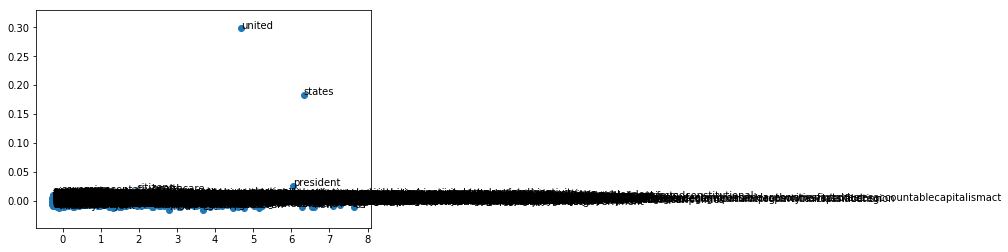

In [518]:
# train model

np_model = train_w2v_model(np_clean)

### r/conservative

In [487]:
# text prep

consrv_df, consrv_raw, consrv_clean, consrv_vocab, consrv_top, consrv_bottom = text_prep_pipeline('conservative', 'conservative', 'conservative_script.txt', 'conservative_secret.txt', 'reddit_id.txt', 25)

So let me get this straight... 

Why we won 

Ben Shapiro on the 4th of July... 

Well, she's a guy, so... 

Reddit Admin u/spez Admits of Editing Users Comments 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


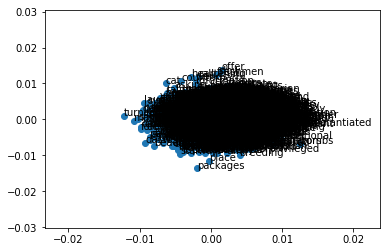

In [488]:
# train model

consrv_model = train_w2v_model(consrv_clean)

In [526]:
# test terms on NeutralPolitics 

np_words_A = ['god','establishment', 'soros', 'prison', 'email', 'corrupt']


np_words_B = ['trump', 'clinton', 'sanders']


np_cos = comp_cos_sim_lists(np_model, np_words_A, np_words_B)

In [528]:
np_cos

[[['god', 'trump', 0.9896451397482763],
  ['god', 'clinton', 0.9894758753679626],
  ['god', 'sanders', 0.9895234517895513]],
 [['establishment', 'trump', 0.997954349028006],
  ['establishment', 'clinton', 0.9980633487980325],
  ['establishment', 'sanders', 0.9979058217842425]],
 [['soros', 'trump', 0.9365046153899573],
  ['soros', 'clinton', 0.9370581438172608],
  ['soros', 'sanders', 0.9364621308259259]],
 [['prison', 'trump', 0.9981425851292374],
  ['prison', 'clinton', 0.998179045797138],
  ['prison', 'sanders', 0.998219910858386]],
 [['email', 'trump', 0.9990500441610523],
  ['email', 'clinton', 0.9991200836490253],
  ['email', 'sanders', 0.998976372498125]],
 [['corrupt', 'trump', 0.9973089771903987],
  ['corrupt', 'clinton', 0.9973618369662011],
  ['corrupt', 'sanders', 0.9972757338973083]]]

In [536]:
# 'establishment' & soros not in vocab


words_A = ['god', 'prison', 'good', 'evil', 'assault']

words_B = ['trump', 'clinton', 'sanders', 'men', 'women']

words_C = ['god', 'prison', 'email', 'corrupt']

words_D = ['trump', 'clinton', 'sanders']


consrv_cos = comp_cos_sim_lists(consrv_model, words_C, words_B)

In [537]:
consrv_cos

[[['god', 'trump', 0.12336896393349152],
  ['god', 'clinton', -0.0018600052715705838],
  ['god', 'sanders', 0.04345256330570199],
  ['god', 'men', 0.21490678227402968],
  ['god', 'women', -0.2345760276084674]],
 [['prison', 'trump', -0.16627451588837824],
  ['prison', 'clinton', -0.06395054060997551],
  ['prison', 'sanders', -0.002689428777214289],
  ['prison', 'men', 0.11621279854790434],
  ['prison', 'women', 0.014032448517674836]],
 [['email', 'trump', -0.014532342774403809],
  ['email', 'clinton', 0.13094265226220414],
  ['email', 'sanders', -0.05823499899236085],
  ['email', 'men', 0.06889136056111136],
  ['email', 'women', 0.09213371142427193]],
 [['corrupt', 'trump', -0.004045955611926437],
  ['corrupt', 'clinton', 0.04754611356337351],
  ['corrupt', 'sanders', -0.011235132689758849],
  ['corrupt', 'men', 0.08456631436905054],
  ['corrupt', 'women', -0.08791362038074332]]]

In [552]:
#consrv_df, consrv_raw, consrv_clean, consrv_vocab, consrv_top, consrv_bottom = 
#text_prep_pipeline('conservative', 'conservative', 'conservative_script.txt', 
#'conservative_secret.txt', 'reddit_id.txt', 25)

RedPill_df, RedPill_raw, RedPill_clean, RedPill_vocab, RedPill_top, RedPill_bottom = text_prep_pipeline('RedPill', 'RedPill', 'RedPill_script.txt', 'RedPill_secret.txt', 'reddit_id.txt', 25)

Looking for... 



In [553]:
Kotaku_df, Kotaku_raw, Kotaku_clean, Kotaku_vocab, Kotaku_top, Kotaku_bottom = text_prep_pipeline('KotakuInAction', 'KotakuInAction', 'Kotaku_script.txt', 'Kotaku_secret.txt', 'reddit_id.txt', 25)

[Humor] There's two kinds of people... 

Reddit bans r/whalewatching thinking its a clone of r/fatpeoplehate. It was actually a real attempt at a whale watching community and has existed for +2 years. 

[CENSORSHIP] The new age of reddit has begun. Admins ban /r/FatPeopleHate (and 4 other subreddits that the admins fail to disclose). 

Pussy Pass Denied mods are being threatened with doxxing if they don't hand over the sub over to SJWs to shut down. One mod has already lost their job. 

[Censorship]Youtube cuts ad revenue for Phillip Defranco for posting Annaliese Nielsen video 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


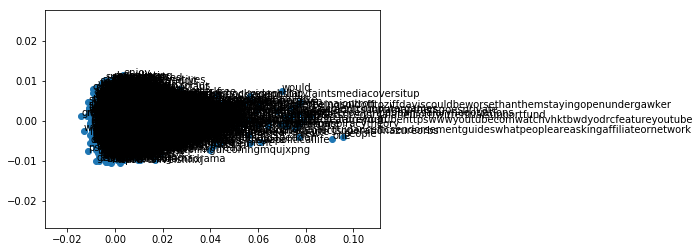

In [554]:
Kotaku_model = train_w2v_model(Kotaku_clean)

In [555]:
'''

words_A = ['god', 'prison', 'good', 'evil', 'assault']

words_B = ['trump', 'clinton', 'sanders', 'men', 'women']

words_C = ['god', 'prison', 'email', 'corrupt']

words_D = ['trump', 'clinton', 'sanders']'''

Kotaku_cos = comp_cos_sim_lists(Kotaku_model, words_A, words_B)

In [556]:
Kotaku_cos

[[['god', 'trump', 0.23206215839914576],
  ['god', 'clinton', 0.024649553455327895],
  ['god', 'sanders', 0.05977597790938829],
  ['god', 'men', 0.33382775974442963],
  ['god', 'women', 0.15980773564955164]],
 [['prison', 'trump', -0.014598633938031551],
  ['prison', 'clinton', -0.01866637545088298],
  ['prison', 'sanders', 0.01455119330823022],
  ['prison', 'men', 0.3017583354178705],
  ['prison', 'women', 0.2848370438471238]],
 [['good', 'trump', 0.4152706841122039],
  ['good', 'clinton', 0.07047875853825088],
  ['good', 'sanders', 0.12477773744345937],
  ['good', 'men', 0.5179290226231024],
  ['good', 'women', 0.7441104895232586]],
 [['evil', 'trump', 0.03590698447331584],
  ['evil', 'clinton', -0.04991328249866519],
  ['evil', 'sanders', -0.12128960042608457],
  ['evil', 'men', 0.08899251476575534],
  ['evil', 'women', 0.06043469955986498]],
 [['assault', 'trump', 0.31151375194463193],
  ['assault', 'clinton', -0.07344135724370475],
  ['assault', 'sanders', 0.005614734671444366],
 

In [558]:
#consrv_df, consrv_raw, consrv_clean, consrv_vocab, consrv_top, consrv_bottom = 
#text_prep_pipeline('conservative', 'conservative', 'conservative_script.txt', 
#'conservative_secret.txt', 'reddit_id.txt', 25)

resist_df, resist_raw, resist_clean, resist_vocab, resist_top, resist_bottom = text_prep_pipeline('esist', 'resist', 'resist_script.txt', 'resist_secret.txt', 'reddit_id.txt', 25)

BREAKING NEWS: Supreme Court finds North Carolina GOP gerrymandering districts based on race 

Trump reveals classified information to Russian Ambassador. 

In the latest AHCA proposal, Republican lawmakers added an amendment to exempt themselves and their staff from the changes. They love Obamacare's protections. They love having pre-existing conditions covered by insurance. They just don't want you to have it too. Call them and ask them why. 

Trump says: "We have to start winning wars again." // NO - How about we not have any wars at all? This administration seems to be ramping up to get us into a war somewhere. Call your representative and tell them WE DON'T WANT ANOTHER WAR. 

Presidential sources: US President Trump calls Turkish President Erdoğan to congratulate him on Turkey referendum result. To be clear, Trump is congratulating him on a measure to effectively eliminate democracy and install a dictatorship. 



In [ ]:
resist_model = train_w2v_model(resist_clean)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
